# Previsão de Preços de Passagens Aéreas com Regressão Linear 

## 1.1. O contexto

O objetivo desse projeto é analisar o dataset de reservas de voos obtido do site indiano "Easy My Trip" e conduzir dois processos: uma Análise Exploratória de Dados e a criação de um modelo de previsão dos preços de passagens. O site é uma plataforma para realizar reservas de voos e comprar passagens, através desse estudo vamos buscar insights para que está planejando uma viagem.

Portando também iremos responder algumas perguntas:

1. Preço varia de acordo com a Linha Aérea? e com a Classe?
2. Como os preços das passagens são afetados, entre 1 e 2 dias antes da viagem?
3. O preço muda de acordo com o período do dia para chegada e partida?
4. O preço muda de acordo com o destino de partida e chegada?

## 1.2. A estrutura do conjunto de dados

As colunas do conjunto de dado estão organizados da seguinte forma

|Coluna|Descrição|
|-------|---------|
|airline|A linha aérea do voo|
|flight|O código de identificação do voo|
|source_city|A cidade de onde o voo está partindo|
|departure_time|Período do dia em qual o voo partiu|
|stops|Número de paradas entre a partida e o destino|
|arrival_time|Período do dia em que o voo chegou|
|destination_city|A cidade destino do voo|
|class|Classe do voo|
|duration|Duração em horas do voo|
|days_left|Diferença entre o dia da viagem e da reserva|
|price|Preço da passagem|

##  1.3. Importando as bibliotecas e carregando o dataset

In [3]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Análise Exploratória de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import model_selection
from sklearn import pipeline
from feature_engine import encoding

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
my_palette = sns.color_palette(["#023E8A", "#0077B6", "#0096C7", "#00B4D8", "#48CAE4", "#90E0EF", "#ADE8F4", "#CAF0F8"])
sns.set_palette(my_palette)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 40)

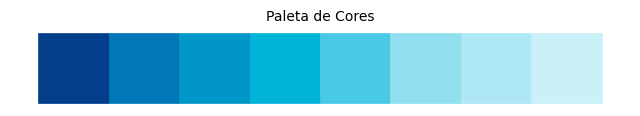

In [4]:
plt.figure(figsize=(8, 1))

for i, cor in enumerate(my_palette):
    plt.fill_between([i, i + 1], 0, 1, color=cor)

plt.axis('off')
plt.title('Paleta de Cores', fontsize = 10)
plt.show()

In [5]:
data = pd.read_csv("../data/raw/Clean_Dataset.csv")
data.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)

# 2. Visão geral dos dados

## 2.1. Estrutura

In [6]:
data.shape

(300153, 11)

In [7]:
data.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 25.2+ MB


## 2.2. Nulos e duplicados

In [9]:
print(f'O dataset tem {data.isnull().sum().sum()} dados nulos.')

O dataset tem 0 dados nulos.


In [10]:
print(f'O dataset tem {data.duplicated().sum()} dados duplicados.')

O dataset tem 0 dados duplicados.


## 2.3. Estatísticas descritivas

In [11]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,300153.0,12.221021,7.191997,0.83,6.83,11.25,16.17,49.83
days_left,300153.0,26.004751,13.561004,1.00,15.00,26.00,38.00,49.00
price,300153.0,20889.660523,22697.767366,1105.00,4783.00,7425.00,42521.00,123071.00


O dataset tem 11 colunas, apenas 3 delas são numéricas. Os tipos dos dados estão corretamente preenchidos mas existe um grande desequilibrio nas distribuições, a média de preços das passagens é aproximadamente 20000 INR(Rupias indianas) e a mediana está em 7400 o que aponta para existência de valores extremos (outliers). As colunas 'duration' e 'days_left' apresentam distribuições com maior simetria. 

# 3. Limpeza e manipulação

## 3.1. Conjuntos de Treino e Teste

In [12]:
train, test = model_selection.train_test_split(data, test_size = 0.20, random_state = 42)

train.to_csv("../data/processed/train.csv", index = False)
test.to_csv("../data/processed/test.csv", index = False)

In [13]:
df = pd.read_csv("../data/processed/train.csv")
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,Air_India,AI-424,Kolkata,Afternoon,one,Morning,Chennai,Economy,19.42,6,13524
1,Indigo,6E-2193,Delhi,Afternoon,two_or_more,Night,Chennai,Economy,7.00,13,9940
2,Air_India,AI-768,Kolkata,Afternoon,one,Afternoon,Chennai,Business,21.17,44,55983
3,Vistara,UK-876,Hyderabad,Night,one,Early_Morning,Bangalore,Economy,10.25,11,7927
4,Vistara,UK-774,Kolkata,Night,one,Night,Chennai,Business,26.50,5,55502


## 3.2. Outliers

#### Coluna 'price'

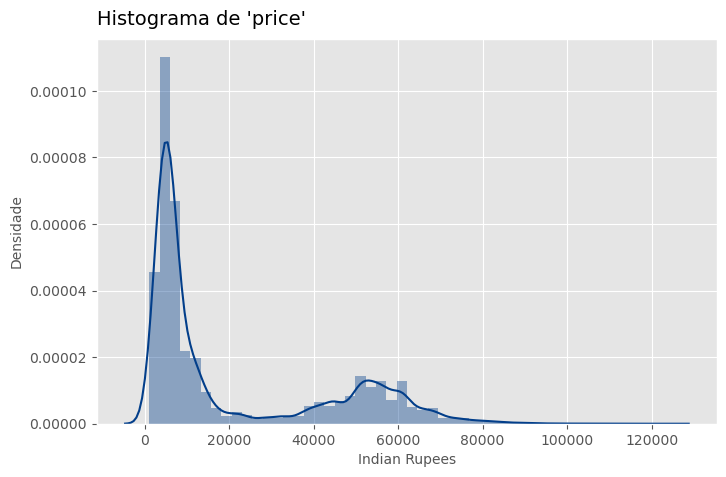

In [14]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.distplot(df['price'])
ax.set_title("Histograma de 'price'", loc = 'left', fontsize = 14, pad = 10)
ax.set_xlabel("Indian Rupees", fontsize = 10)
ax.set_ylabel("Densidade", fontsize = 10)
plt.show()

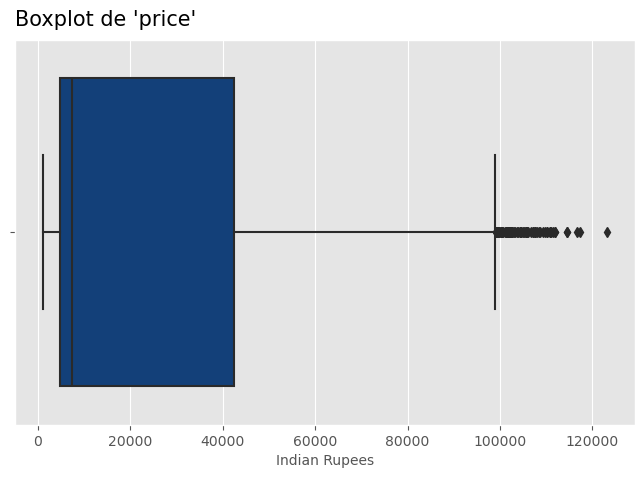

In [15]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.boxplot(x = df['price'])
ax.set_title("Boxplot de 'price'", loc = 'left', fontsize = 15, pad = 10)
ax.set_xlabel("Indian Rupees", fontsize = 10)
plt.show()

Existe uma assimétria a direita nos dados e será necessária a remoção dos outliers.

In [17]:
# Definindo o intervalo interquartil
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites
lim_superior = Q3 + 1.5 * IQR
lim_inferior = Q1 - 1.5 * IQR

# Dados sem outliers
df = df[(df['price'] > lim_inferior) & (df['price'] < lim_superior)].copy()
df.reset_index()
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,Air_India,AI-424,Kolkata,Afternoon,one,Morning,Chennai,Economy,19.42,6,13524
1,Indigo,6E-2193,Delhi,Afternoon,two_or_more,Night,Chennai,Economy,7.00,13,9940
2,Air_India,AI-768,Kolkata,Afternoon,one,Afternoon,Chennai,Business,21.17,44,55983
3,Vistara,UK-876,Hyderabad,Night,one,Early_Morning,Bangalore,Economy,10.25,11,7927
4,Vistara,UK-774,Kolkata,Night,one,Night,Chennai,Business,26.50,5,55502


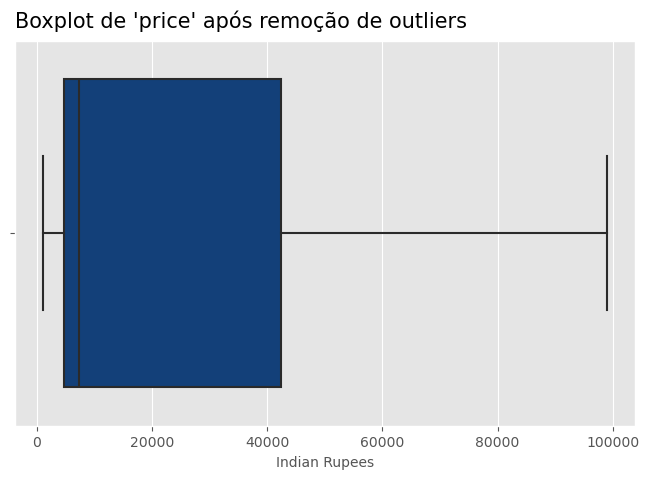

In [21]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.boxplot(x = df['price'])
ax.set_title("Boxplot de 'price' após remoção de outliers", loc = 'left', fontsize = 15, pad = 10)
ax.set_xlabel("Indian Rupees", fontsize = 10)
plt.show()

#### Coluna 'duration'

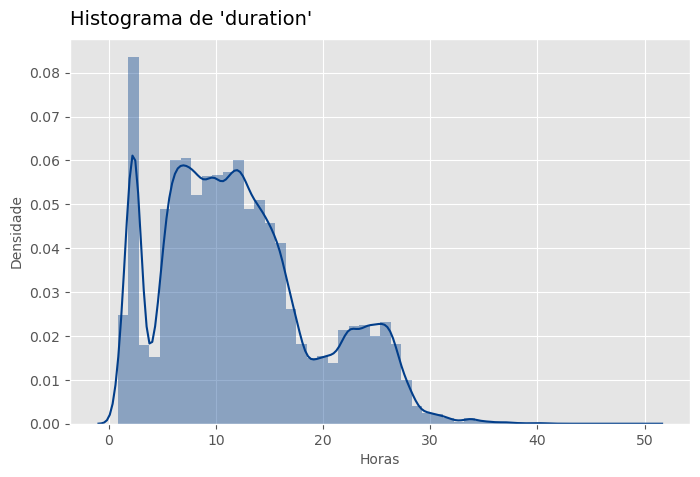

In [25]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.distplot(df['duration'])
ax.set_title("Histograma de 'duration'", loc = 'left', fontsize = 14, pad = 10)
ax.set_xlabel("Horas", fontsize = 10)
ax.set_ylabel("Densidade", fontsize = 10)
plt.show()

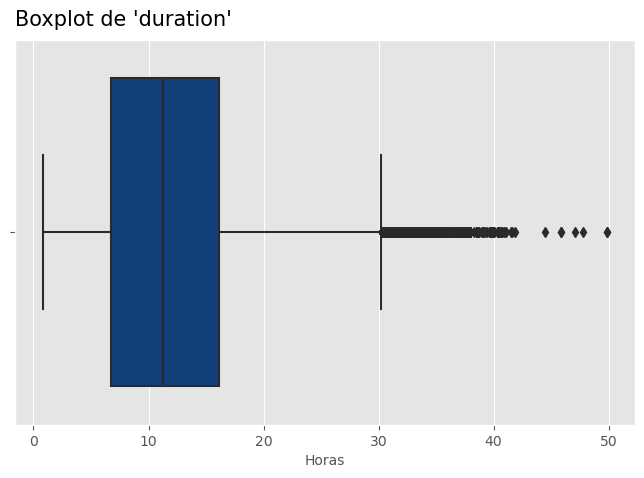

In [26]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.boxplot(x= df['duration'])
ax.set_title("Boxplot de 'duration'", loc = 'left', fontsize = 15, pad = 10)
ax.set_xlabel("Horas", fontsize = 10)
plt.show()

In [27]:
# Definindo o intervalo interquartil
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites
lim_superior = Q3 + 1.5 * IQR
lim_inferior = Q1 - 1.5 * IQR

# Dados sem outliers
df = df[(df['duration'] > lim_inferior) & (df['duration'] < lim_superior)].copy()
df.reset_index()
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,Air_India,AI-424,Kolkata,Afternoon,one,Morning,Chennai,Economy,19.42,6,13524
1,Indigo,6E-2193,Delhi,Afternoon,two_or_more,Night,Chennai,Economy,7.00,13,9940
2,Air_India,AI-768,Kolkata,Afternoon,one,Afternoon,Chennai,Business,21.17,44,55983
3,Vistara,UK-876,Hyderabad,Night,one,Early_Morning,Bangalore,Economy,10.25,11,7927
4,Vistara,UK-774,Kolkata,Night,one,Night,Chennai,Business,26.50,5,55502


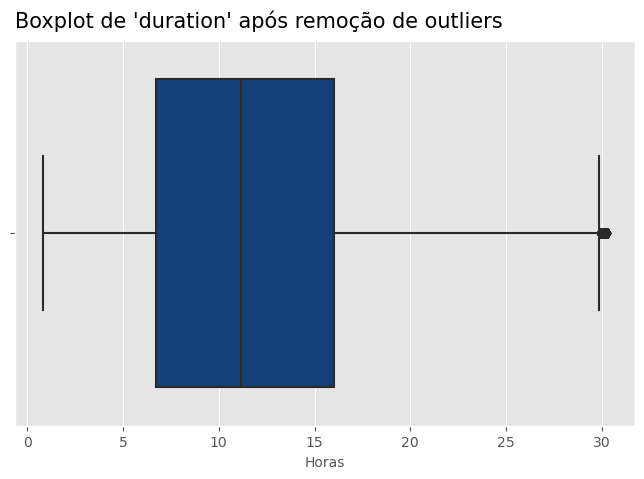

In [28]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.boxplot(x = df['duration'])
ax.set_title("Boxplot de 'duration' após remoção de outliers", loc = 'left', fontsize = 15, pad = 10)
ax.set_xlabel("Horas", fontsize = 10)
plt.show()

#### Coluna 'days_left'

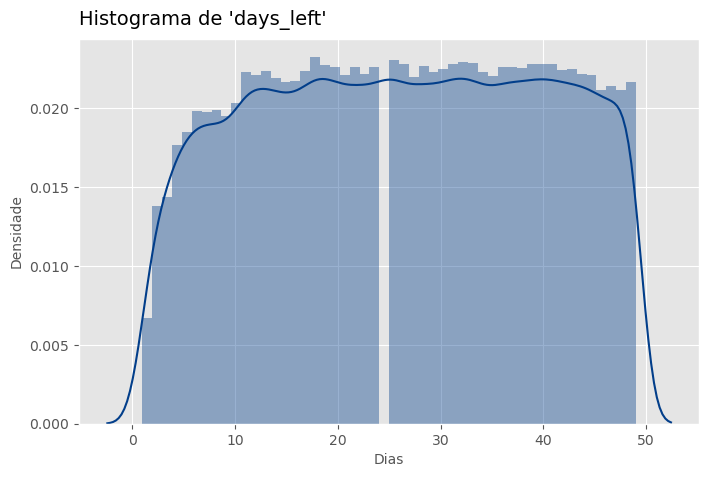

In [31]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.distplot(df['days_left'])
ax.set_title("Histograma de 'days_left'", loc = 'left', fontsize = 14, pad = 10)
ax.set_xlabel("Dias", fontsize = 10)
ax.set_ylabel("Densidade", fontsize = 10)
plt.show()

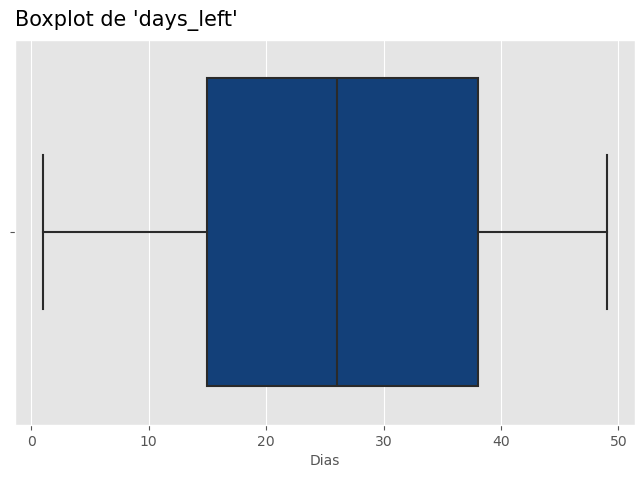

In [32]:
fig, ax = plt.subplots(figsize = (8, 5))

sns.boxplot(x= df['days_left'])
ax.set_title("Boxplot de 'days_left'", loc = 'left', fontsize = 15, pad = 10)
ax.set_xlabel("Dias", fontsize = 10)
plt.show()

Apesar da curtose platicúrtica, 'days_left' não apresenta outliers

# 4. Análise Exploratória de Dados

## 4.1. O preço varia de acordo com a Linha Aérea? e com Classe?

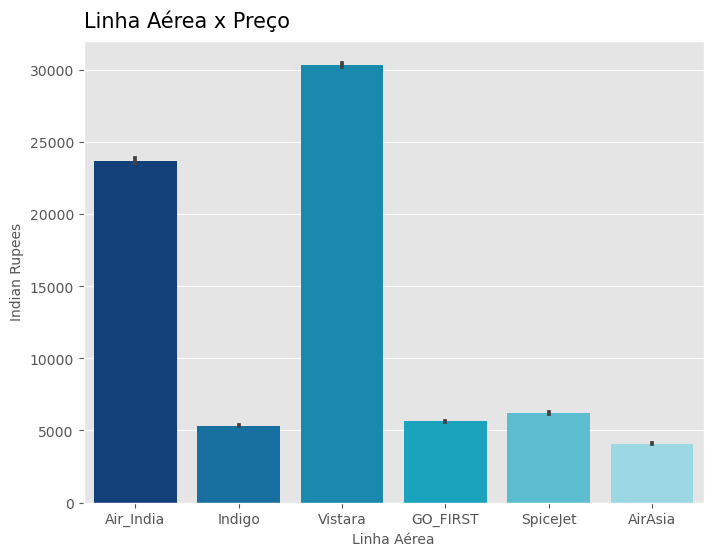

In [36]:
fig, ax = plt.subplots(figsize = (8, 6))

sns.barplot(df, x = 'airline', y = 'price')
ax.set_title("Linha Aérea x Preço", loc = 'left', fontsize = 15, pad = 10)
ax.set_xlabel("Linha Aérea", fontsize = 10)
ax.set_ylabel("Indian Rupees", fontsize = 10)
plt.show()

In [40]:
df.groupby(["airline", "class"])["class"].count()

airline    class   
AirAsia    Economy     12848
Air_India  Business    26254
           Economy     37311
GO_FIRST   Economy     18556
Indigo     Economy     34468
SpiceJet   Economy      7240
Vistara    Business    48284
           Economy     53463
Name: class, dtype: int64

Vistara e Air India tem os valores de passagem mais caros me média por serem as únicas empresas no conjunto de dados a oferecem voos da categória Business, que conta com os maiores preços. 

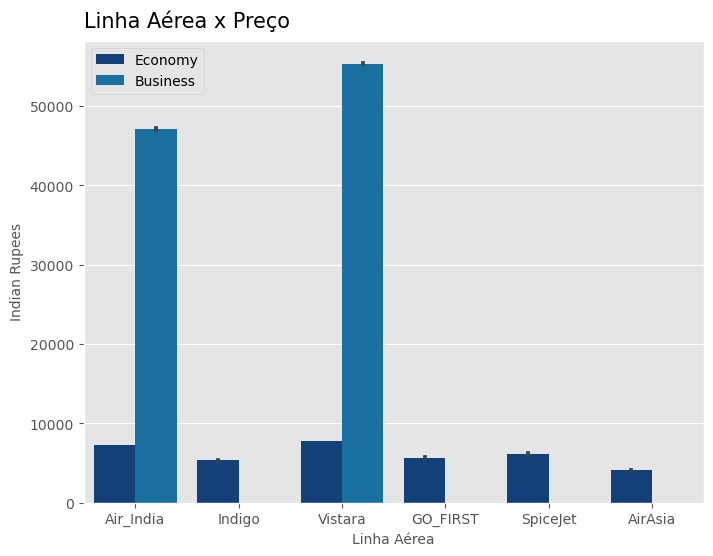

In [67]:
fig, ax = plt.subplots(figsize = (8, 6))

sns.barplot(df, x = 'airline', y = 'price', hue = 'class')
ax.set_title("Linha Aérea x Preço", loc = 'left', fontsize = 15, pad = 10)
ax.set_xlabel("Linha Aérea", fontsize = 10)
ax.set_ylabel("Indian Rupees", fontsize = 10)
plt.legend()
plt.show()

## 4.2. Como os preços das passagens são afetados, entre 1 e 2 dias antes da viagem?

In [45]:
def maior(i):
    if i > 2:
        return 'Mais de 2 dias'
    else:
        return 'Menos de 2 dias'

In [46]:
df_days = df.copy()
df_days['days'] = df['days_left'].apply(maior)

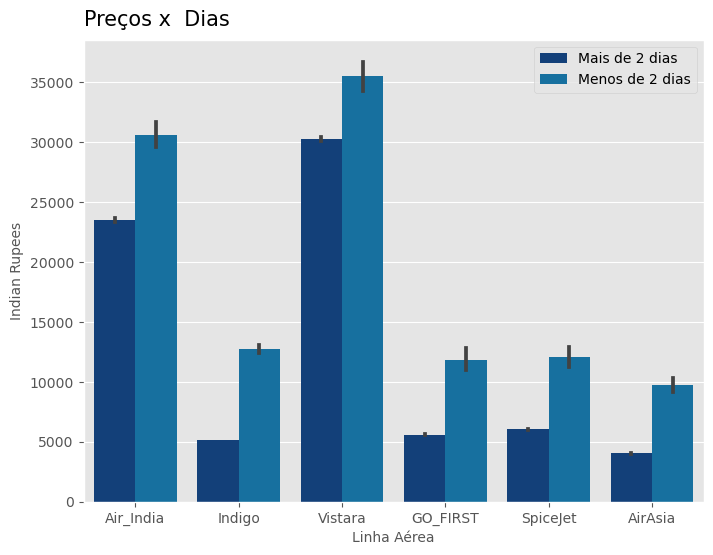

In [47]:
fig, ax = plt.subplots(figsize = (8, 6))

sns.barplot(df_days, x = 'airline', y = 'price', hue = 'days')
ax.set_title("Preços x  Dias", loc = 'left', fontsize = 15, pad = 10)
ax.set_xlabel("Linha Aérea", fontsize = 10)
ax.set_ylabel("Indian Rupees", fontsize = 10)
plt.legend()
plt.show()

Quanto antes forem compras as passagens melhores serão as ofertas de preço. 

## 4.3. O preço muda de acordo com o período do dia para chegada e partida?

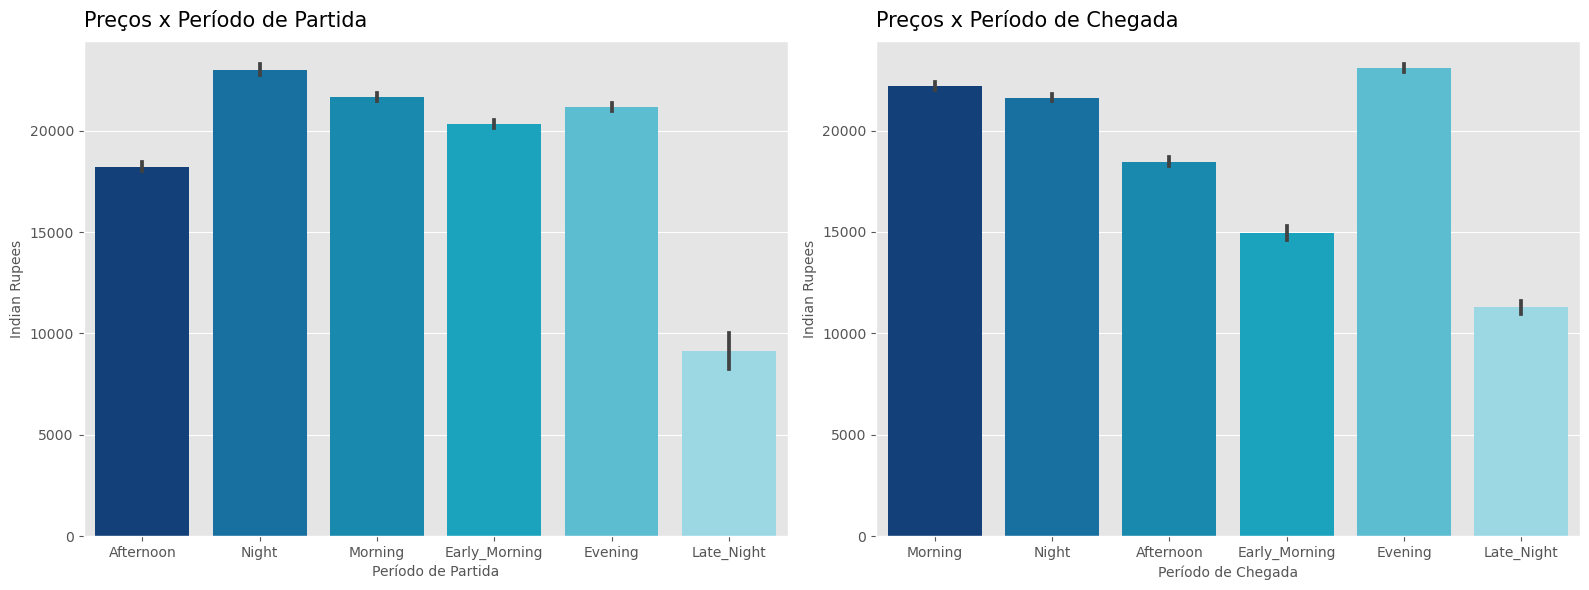

In [49]:
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

sns.barplot(ax = axes[0], data = df, x ='departure_time', y = 'price')
axes[0].set_title("Preços x Período de Partida", loc = 'left', fontsize = 15, pad = 10)
axes[0].set_xlabel("Período de Partida", fontsize = 10)
axes[0].set_ylabel("Indian Rupees", fontsize = 10)

sns.barplot(ax = axes[1], data = df, x = 'arrival_time', y = 'price')
axes[1].set_title("Preços x Período de Chegada", loc = 'left', fontsize = 15, pad = 10)
axes[1].set_xlabel("Período de Chegada", fontsize = 10)
axes[1].set_ylabel("Indian Rupees", fontsize = 10)

plt.tight_layout()
plt.show()

A madrugada também é o melhor período para comprar passagens de chegada. Se tornando o período ideal para comprar passagens seguido pela tarde e o começo da manhã.

## 4.4. O preço muda de acordo com o destino de partida e chegada?

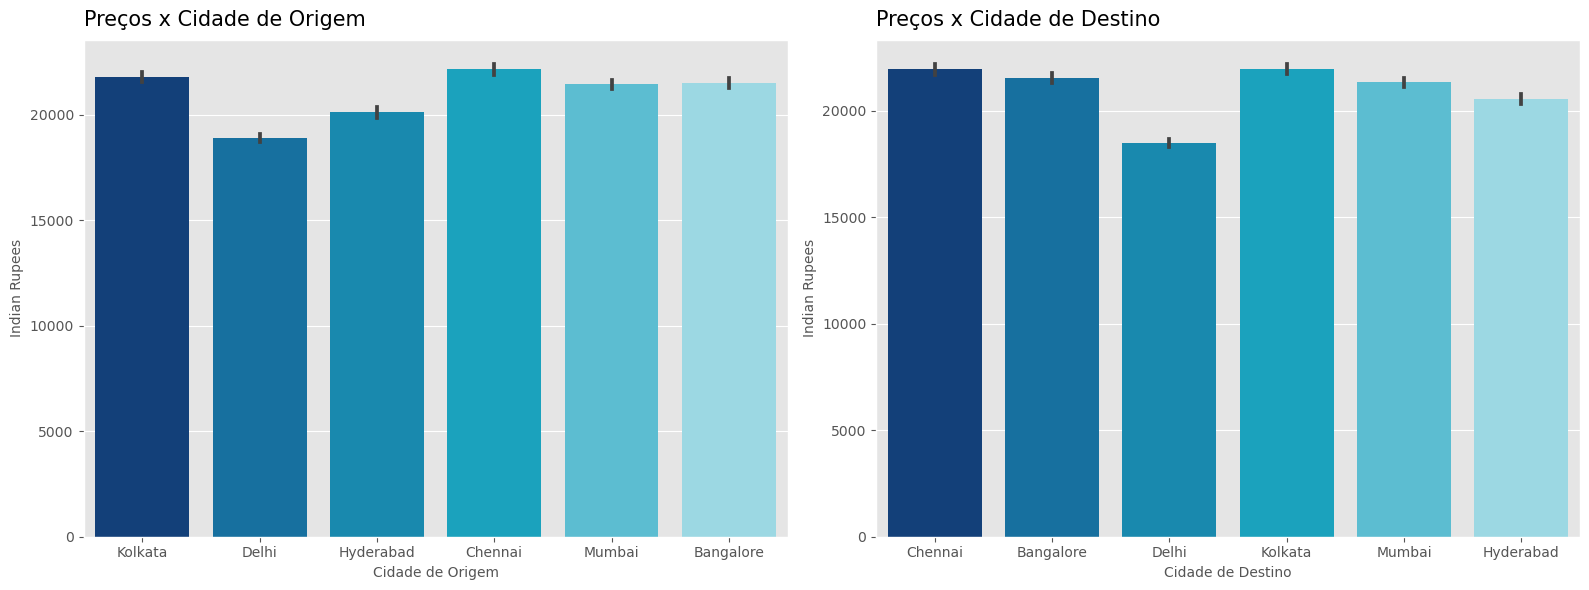

In [57]:
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

sns.barplot(ax = axes[0], data = df, x = 'source_city', y = 'price')
axes[0].set_title("Preços x Cidade de Origem", loc = 'left', fontsize = 15, pad = 10)
axes[0].set_xlabel("Cidade de Origem", fontsize = 10)
axes[0].set_ylabel("Indian Rupees", fontsize = 10)

sns.barplot(ax = axes[1], data = df, x = 'destination_city', y = 'price')
axes[1].set_title("Preços x Cidade de Destino", loc = 'left', fontsize = 15, pad = 10)
axes[1].set_xlabel("Cidade de Destino", fontsize = 10)
axes[1].set_ylabel("Indian Rupees", fontsize = 10)

plt.tight_layout()

plt.show()

Sim, os pontos de partida e destino tem influência no preço. Delhi é o destino mais barato, seguido por Hyderabad.

# 5. Modelo de Regressão com XGBoost

## 5.2. Seleção das features

In [59]:
X = [
 'airline',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class',
 'duration',
 'days_left'
 ]

y = 'price'

# Dividindo as variáveis e numéricas

cat_features = ['airline',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class']

num_features = ['duration', 'days_left', 'price']

# Dividindo os conjuntos de treino e teste

X_train, X_test, y_train, y_test = model_selection.train_test_split(df[X], 
                                                                    df[y], 
                                                                    test_size=0.20, 
                                                                    random_state=42)

print(f"Preço média da passagem em treino {y_train.mean()}")
print(f"Preço média da passagem em teste {y_test.mean()}")

Preço média da passagem em treino 20906.77329229995
Preço média da passagem em teste 20826.836279752544


## 5.2. Pipeline

In [60]:
# One Hot Encoding
onehot = encoding.OneHotEncoder(variables=cat_features)

# Modelo
model = XGBRegressor(random_state=42)

# Pipeline
xgb_pipeline = pipeline.Pipeline([
    ('ohe', onehot),
    ('model', model)
])

xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ohe',
                 OneHotEncoder(variables=['airline', 'source_city',
                                          'departure_time', 'stops',
                                          'arrival_time', 'destination_city',
                                          'class'])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [61]:
# Predições
y_train_predict = xgb_pipeline.predict(X_train)
y_test_predict = xgb_pipeline.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_predict)
r2_train = r2_score(y_train, y_train_predict)

mse_test = mean_squared_error(y_test, y_test_predict)
r2_test = r2_score(y_test, y_test_predict)

## 5.3. Métricas

In [62]:
print("Métricas de Treino")
print("=" * 40)
print(f"Mean Squared Error: {mse_train}")
print(f"R2 Score: {r2_train}")
print("\nMétricas de Teste")
print("=" * 40)
print(f"Mean Squared Error: {mse_test}")
print(f"R2 Score: {r2_test}")

Métricas de Treino
Mean Squared Error: 10651188.460108126
R2 Score: 0.979316234588623

Métricas de Teste
Mean Squared Error: 11083526.829540076
R2 Score: 0.9783456325531006


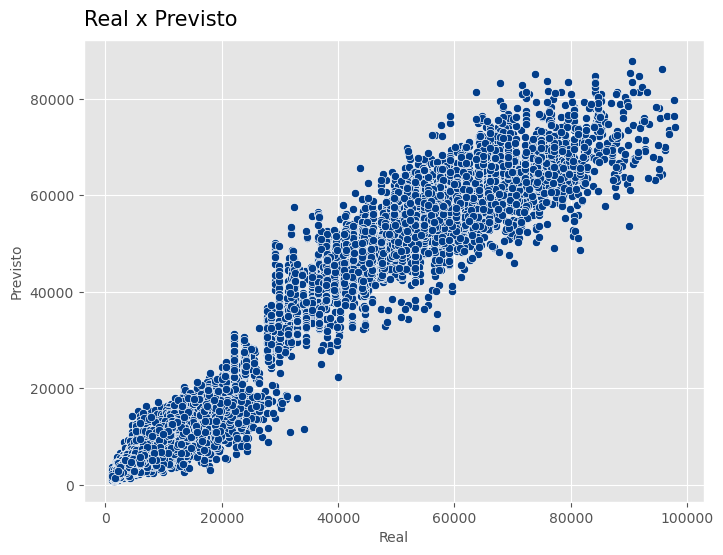

In [65]:
fig, ax = plt.subplots(figsize = (8, 6))

sns.scatterplot(x = y_test, y = y_test_predict)
ax.set_title("Real x Previsto", loc = 'left', fontsize = 15, pad = 10)
ax.set_xlabel("Real", fontsize = 10)
ax.set_ylabel("Previsto", fontsize = 10)
plt.show()

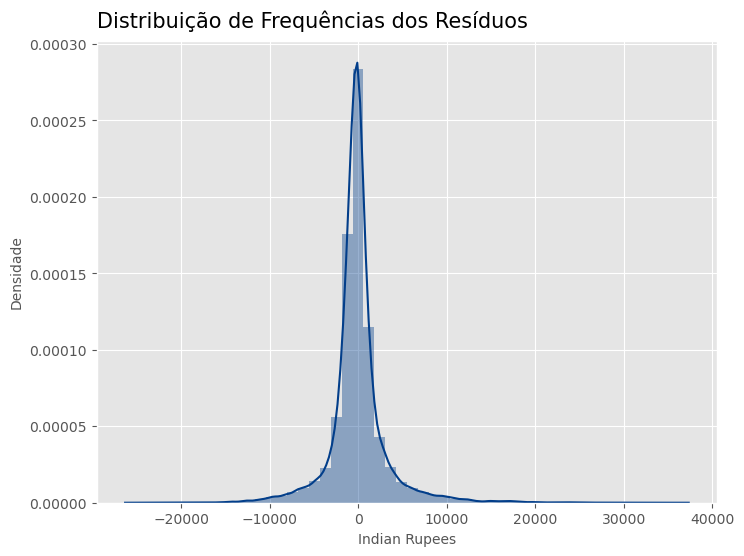

In [66]:
residuo = y_test - y_test_predict
fig, ax = plt.subplots(figsize = (8, 6))

sns.distplot(residuo, kde = True)
ax.set_title("Distribuição de Frequências dos Resíduos", loc = 'left', fontsize = 15, pad = 10)
ax.set_xlabel("Indian Rupees", fontsize = 10)
ax.set_ylabel("Densidade", fontsize = 10)
plt.show()

# 6. Conclusões
##### Respondendo as perguntas iniciais
1. As companhias aéreas com maior valor de passagem são a Vistara e Air India, o que é natural já que são as únicas que oferecem voos de classe executiva, sendo esses os voos com passagens mais caras.
2. Comprar passagens com antecedência vai trazer melhores ofertas nos preços,quanto mais próxima ao voo mais cara é a passagem.
3. Viajar de madrugada e cedo na manhã é mais barato que em outros períodos do dia.
4. Delhi e Hyderabad são os destinos de viagem mais baratos no conjunto de dados, e Chennai o destino mais caro.

##### Sobre o modelo
Com a utilização do algoritmo XGBRegressor conseguimos uma ótima métrica de coeficiente de determinação, em 0.97, com a aplicação deste modelo será possível prever com segurança os preços de passagens aéreas.